In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import segmentation
import numpy as np
import os
import timm
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Stage 1: Classification between normal and abnormal
stage1_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False)
stage1_model.fc = nn.Sequential(
    nn.Linear(stage1_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)  # 2 classes: normal or abnormal
)
stage1_model.to(device)
stage1_model.eval()

# Load pre-trained weights for stage 1
stage1_model.load_state_dict(torch.load('/kaggle/input/final_model_v2/pytorch/v1/1/stage 1.pth'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [10]:
# Stage 2: Segmentation
stage2_model = segmentation.deeplabv3_resnet50(pretrained=False)
stage2_model.classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)
stage2_model.to(device)
stage2_model.eval()

state_dict = torch.load('/kaggle/input/final_model_v2/pytorch/v1/1/stage 2.pth')

expected_keys = stage2_model.state_dict().keys()
state_dict = {k: v for k, v in state_dict.items() if k in expected_keys}

stage2_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [11]:
# Stage 3: Classification between benign and malignant
stage3_model = timm.create_model('inception_v4', pretrained=False)
stage3_model.last_linear = nn.Sequential(
    nn.Linear(stage3_model.last_linear.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)  # 2 classes: benign or malignant
)
stage3_model.to(device)
stage3_model.eval()

# Load pre-trained weights for stage 3
stage3_model.load_state_dict(torch.load('/kaggle/input/final_model_v2/pytorch/v3/1/Stage 3.pth'))

<All keys matched successfully>

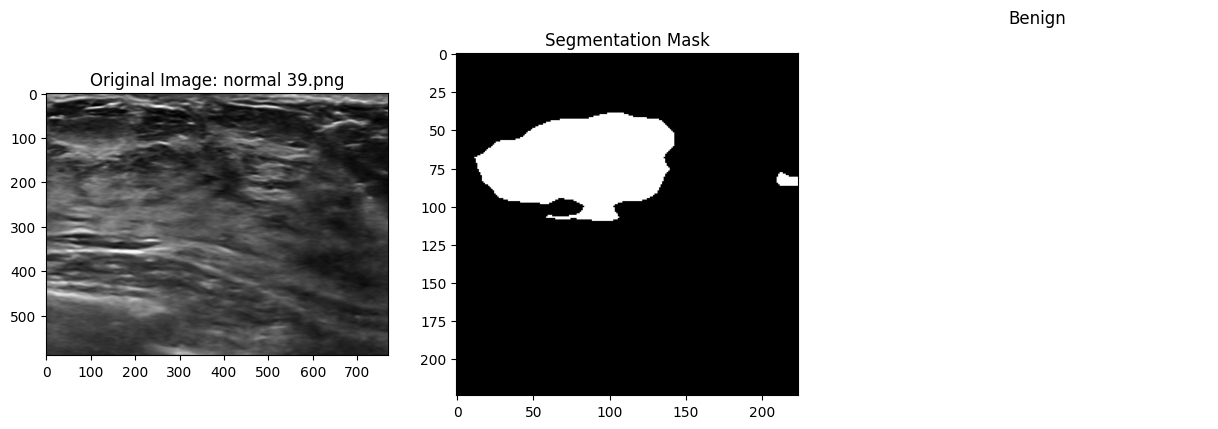

Image normal 17.png is predicted as normal - stage 1


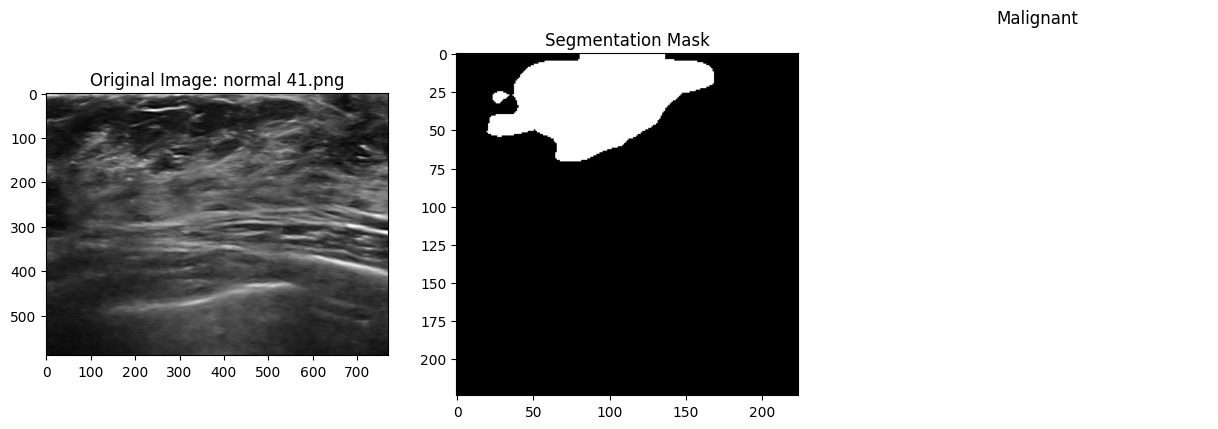

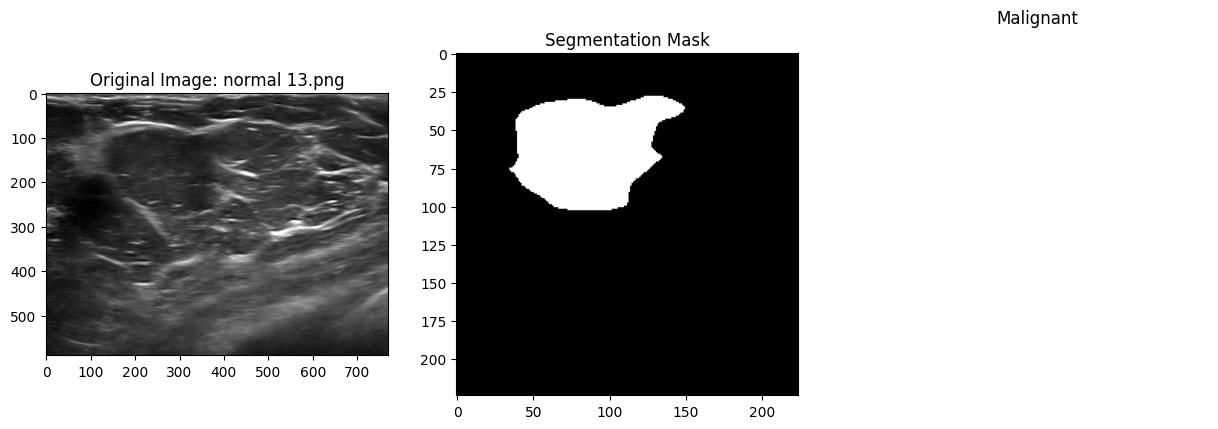

Image normal 34.png is predicted as normal - stage 1
Image normal 29.png is predicted as normal - black mask
Image normal 7.png is predicted as normal - stage 1


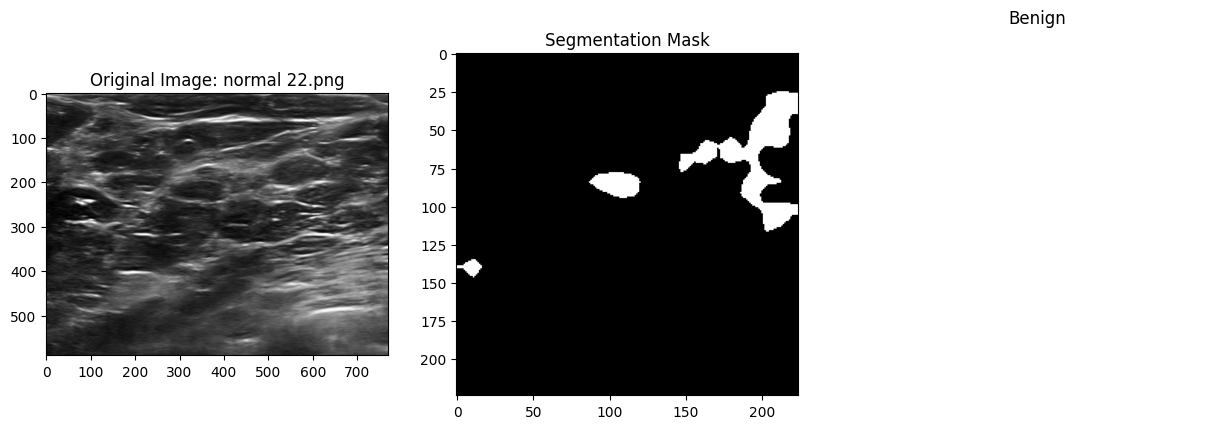

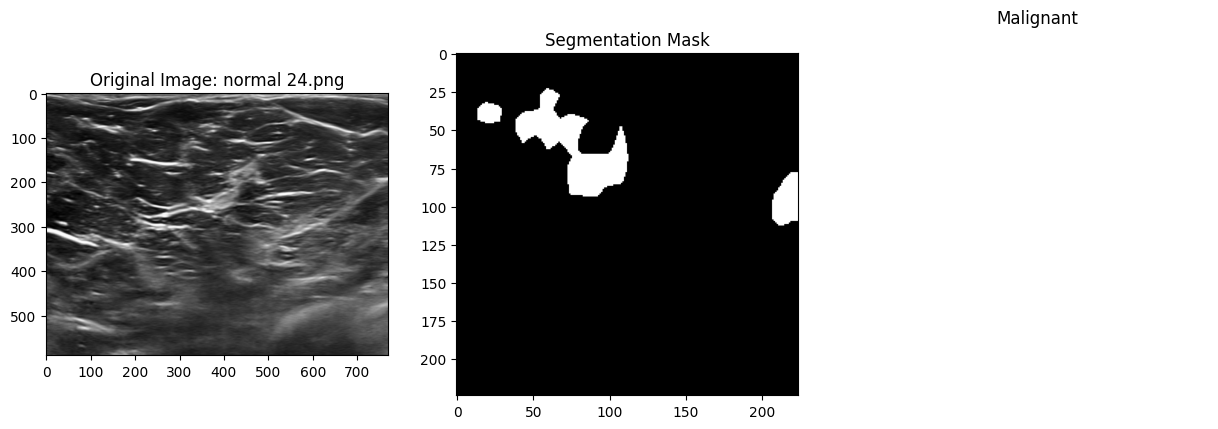

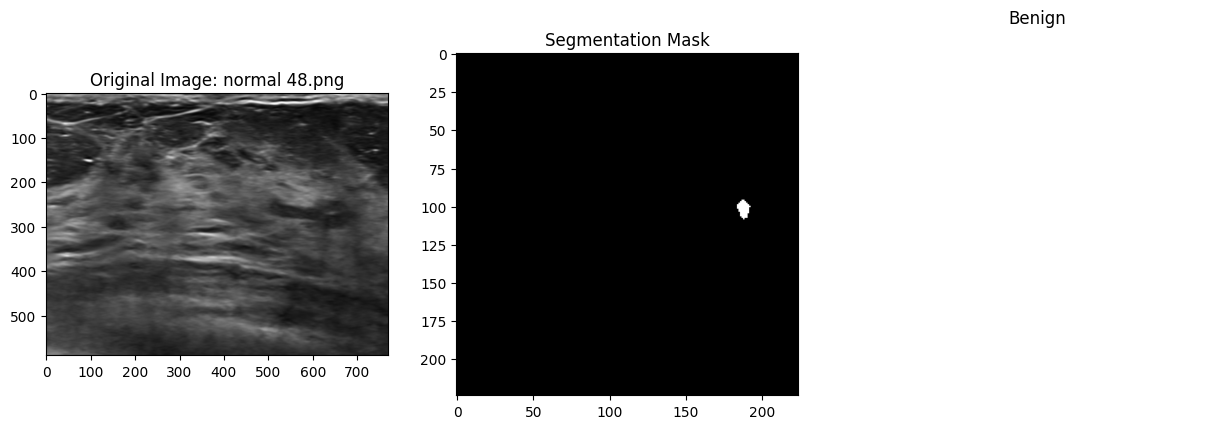

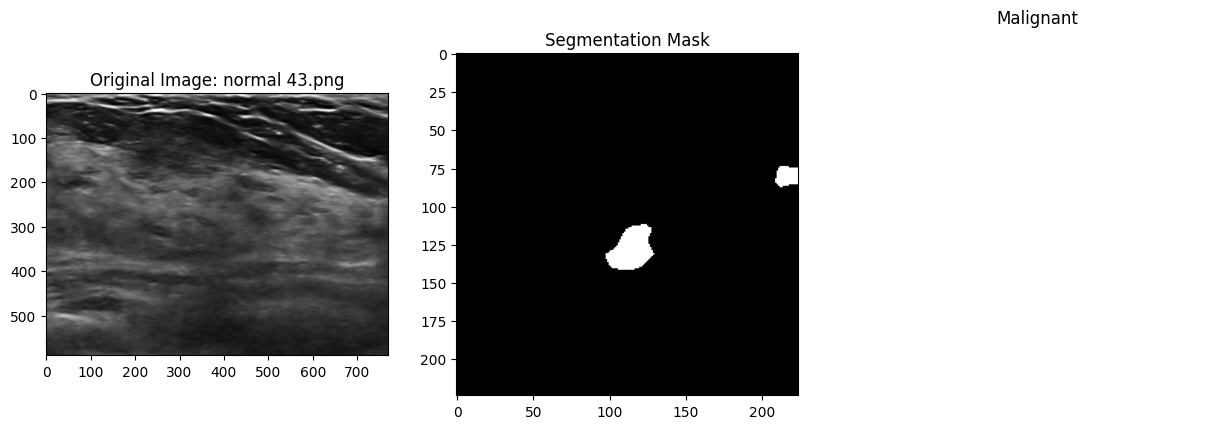

Image normal 26.png is predicted as normal - stage 1


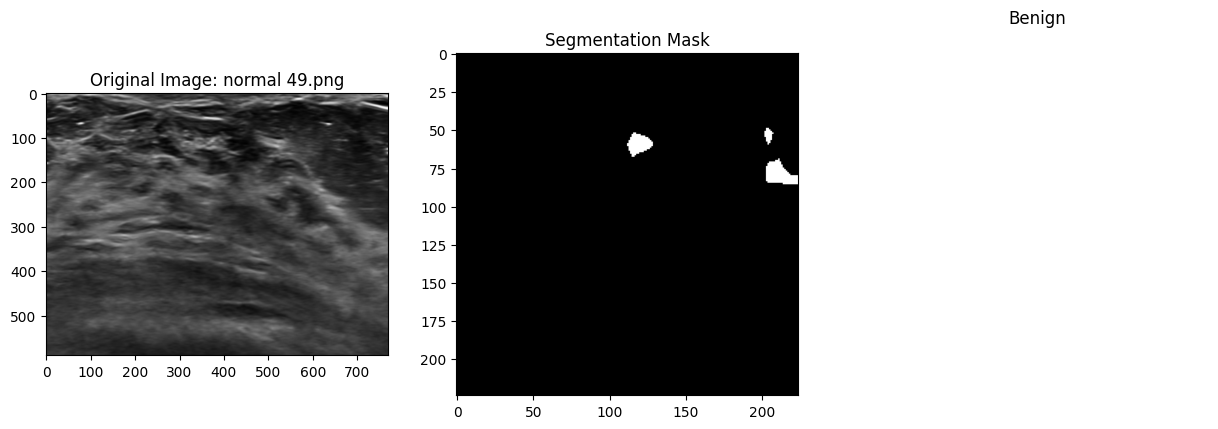

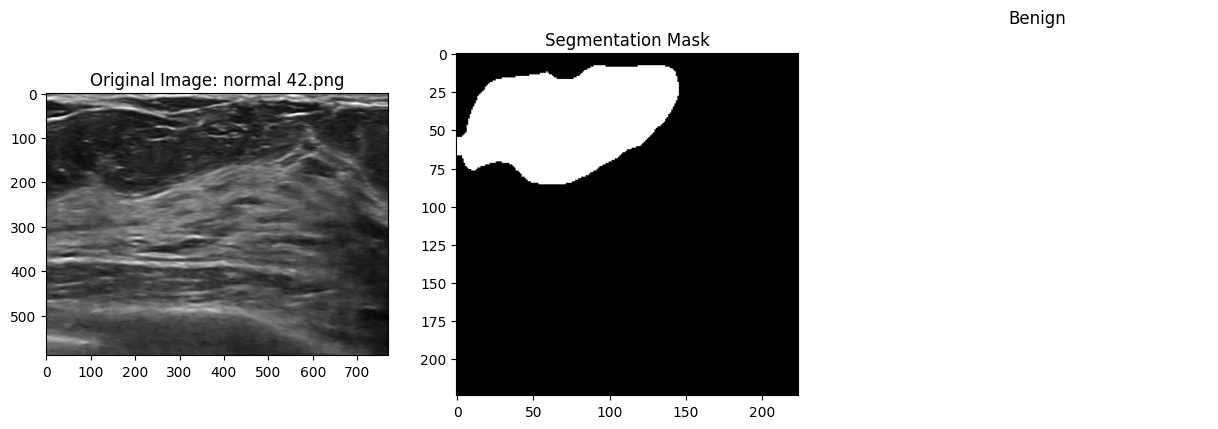

Image normal 1.png is predicted as normal - stage 1
Image normal 36.png is predicted as normal - stage 1
Image normal 23.png is predicted as normal - stage 1
Image normal 3.png is predicted as normal - stage 1
Image normal 10.png is predicted as normal - stage 1


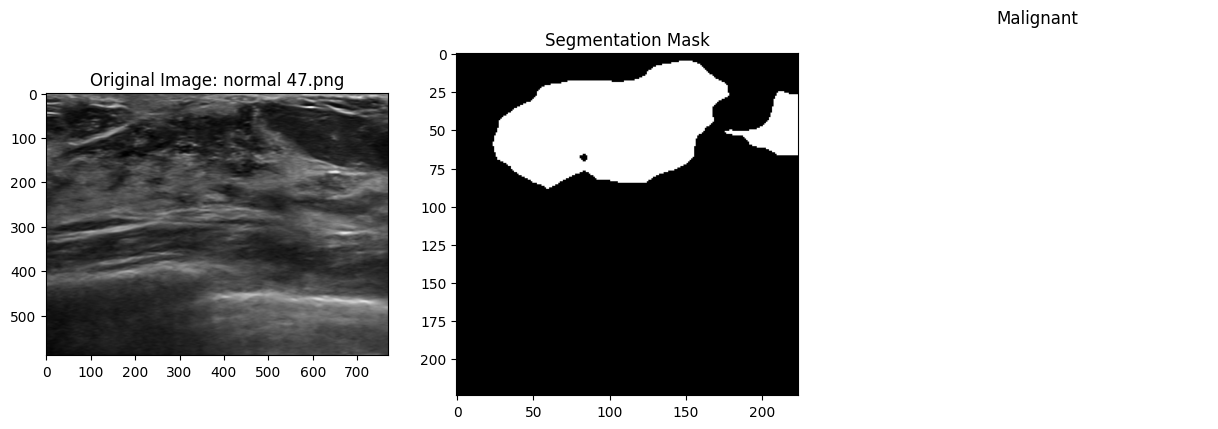

Image normal 2.png is predicted as normal - stage 1
Image normal 21.png is predicted as normal - stage 1
Image normal 32.png is predicted as normal - stage 1
Image normal 11.png is predicted as normal - stage 1
Image normal 18.png is predicted as normal - stage 1


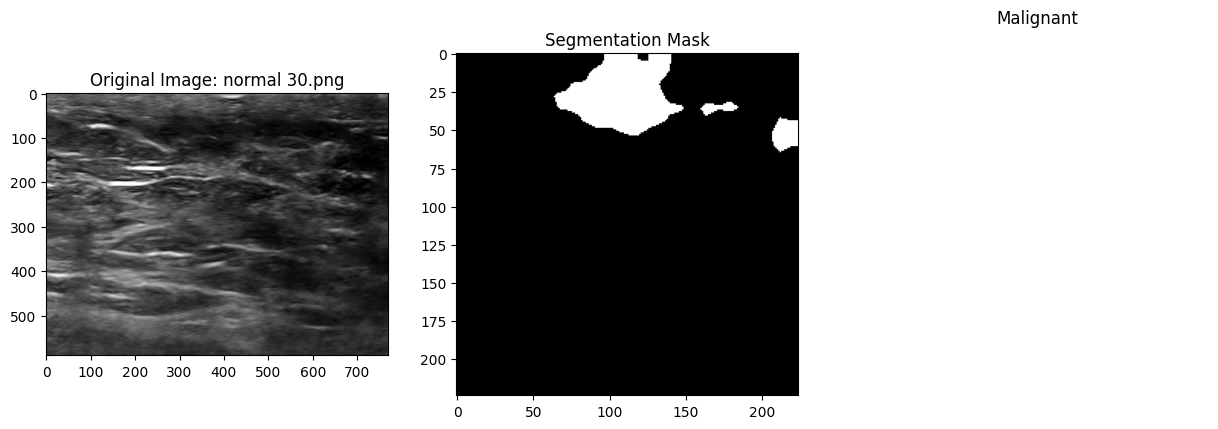

Image normal 0.png is predicted as normal - stage 1
Image normal 46.png is predicted as normal - stage 1
Image normal 25.png is predicted as normal - stage 1
Image normal 5.png is predicted as normal - stage 1


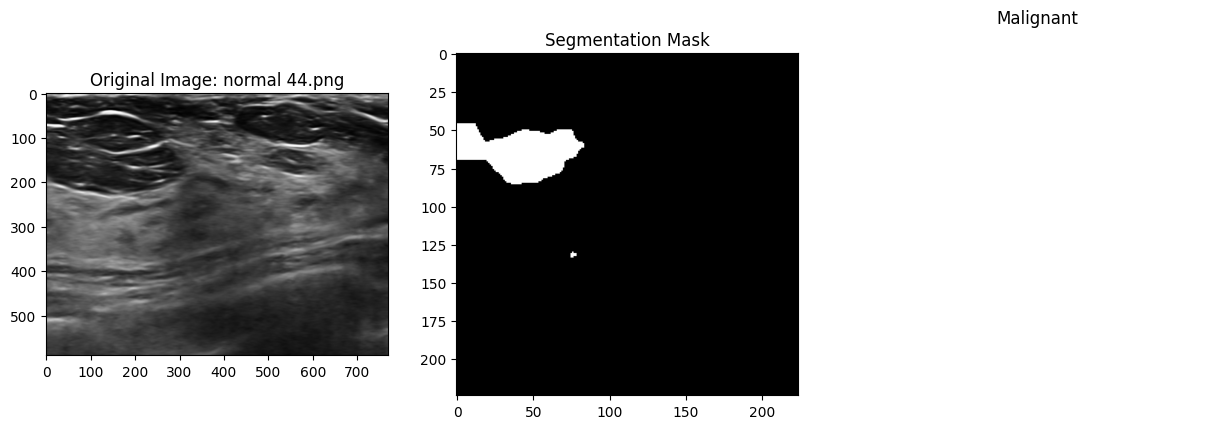

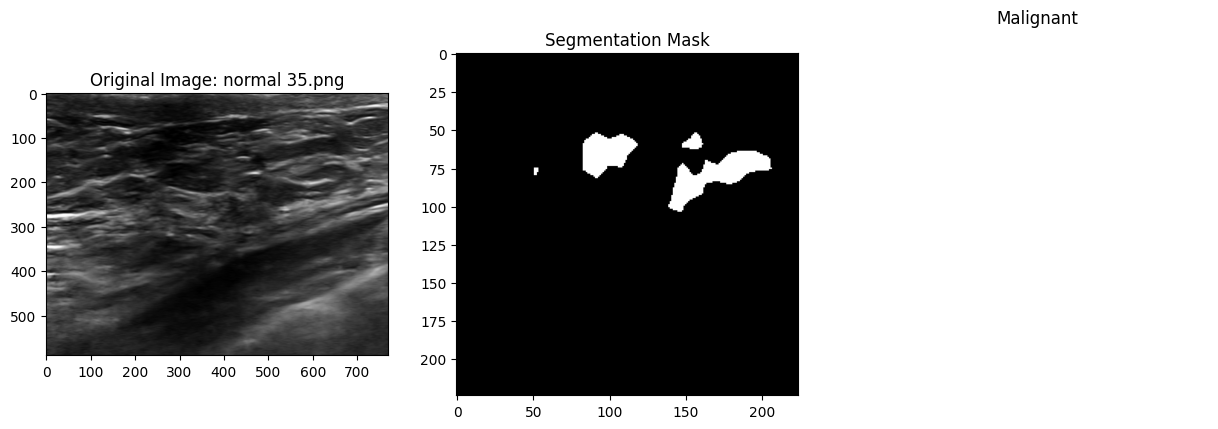

Image normal 28.png is predicted as normal - black mask
Image normal 8.png is predicted as normal - stage 1
Image normal 14.png is predicted as normal - stage 1
Image normal 4.png is predicted as normal - stage 1
Image normal 6.png is predicted as normal - stage 1


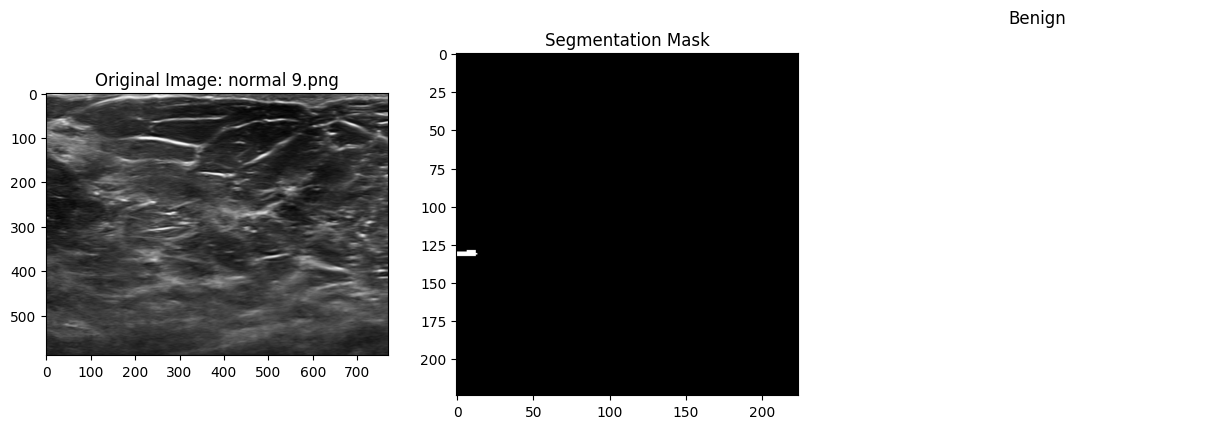

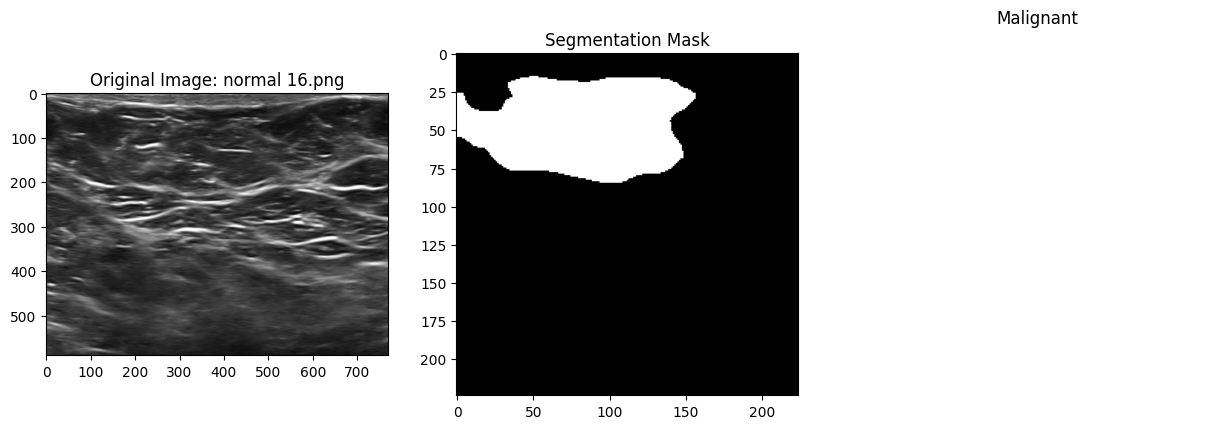

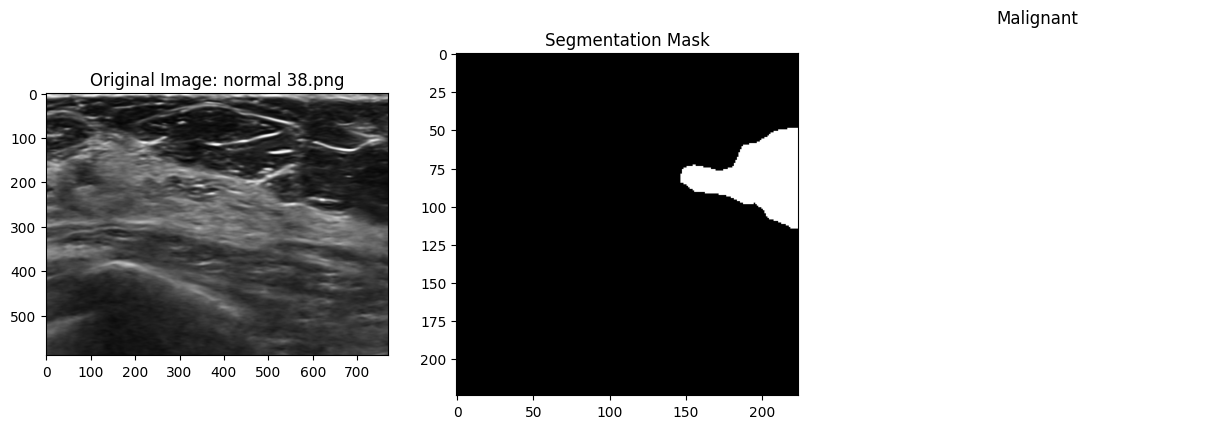

Image normal 27.png is predicted as normal - stage 1
Image normal 31.png is predicted as normal - stage 1
Image normal 33.png is predicted as normal - stage 1
Image normal 37.png is predicted as normal - black mask


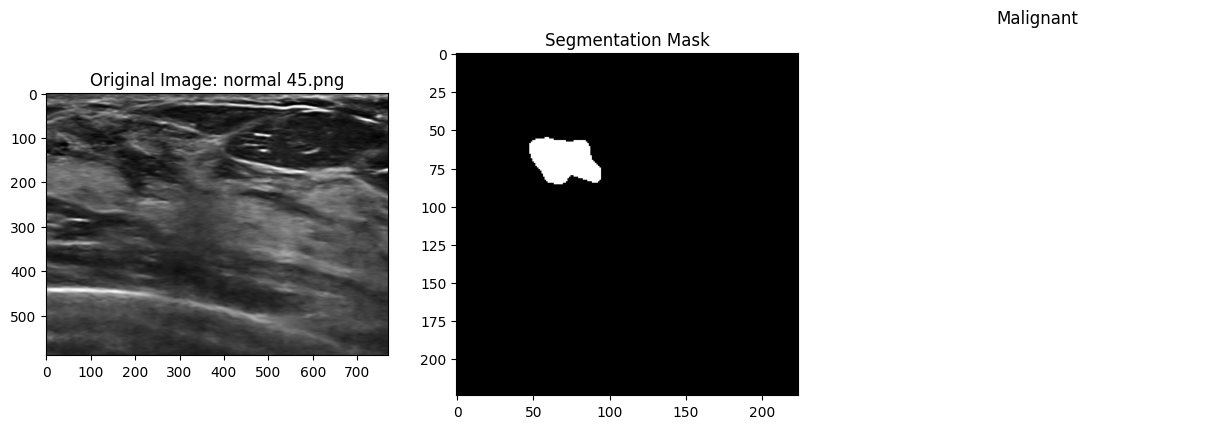

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [15]:
# Load dataset with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Define the directories for the images
dirs = ['/kaggle/input/evalset/Testing/normal', 
        '/kaggle/input/evalset/Testing/benign', 
        '/kaggle/input/evalset/Testing/malignant']

# Initialize counters
total = 0
correct = 0

# Loop over the directories and images
for dir in dirs:
    for file in os.listdir(dir):
        # Open the image file
        with Image.open(os.path.join(dir, file)) as img:
            img_t = transform(img)
            batch_t = torch.unsqueeze(img_t, 0)

            # Stage 1: Normal vs Abnormal
            out = stage1_model(batch_t.to(device))
            _, pred_stage1 = torch.max(out, 1)

            # If the image is predicted as normal, skip visualization
            if pred_stage1.item() == 0:
                print(f"Image {file} is predicted as normal - stage 1")
                total += 1
                if 'normal' in file:
                    correct += 1
                continue
            
            # Stage 2: Segmentation
            outputs = stage2_model(batch_t.to(device))  # Move the input data to the GPU

            # If 'out' is in the dictionary keys, extract it as the mask
            if 'out' in outputs:
                mask = outputs['out']

            # Ensure the mask is a binary mask (you might need to adjust the threshold value)
            mask = (mask > 0.8).float()
            
            if torch.sum(mask) == 0:
                print(f"Image {file} is predicted as normal - black mask")
                total += 1
                if 'normal' in file:
                    correct += 1
                    continue

            # Apply the mask to the image
            img_masked_t = (img_t.to(device)) * mask  # Move img_t to the GPU

            # Stage 3: Benign vs Malignant
            out_stage3 = stage3_model(img_masked_t.to(device))  # Move the input data to the GPU
            _, pred_stage3 = torch.max(out_stage3, 1)

            # Visualization
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Original image
            axes[0].imshow(img)
            axes[0].set_title(f'Original Image: {file}')

            # Mask from Stage 2
            axes[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
            axes[1].set_title('Segmentation Mask')

            # Final output (Benign, Normal, or Malignant)
            if pred_stage3.item() == 0:
                axes[2].set_title('Benign')
            else:
                axes[2].set_title('Malignant')
            axes[2].axis('off')
            
            plt.show()

            # Update correct count
            if ('Benign' in file and pred_stage3.item() == 0) or ('Malignant' in file and pred_stage3.item() == 1):
                correct += 1

            total += 1

print(f'Total images: {total}, Correct predictions: {correct}')

In [ ]:
# Calculate the accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy}')

In [ ]:
total